# Milestone Project 2: SkimLit 📄🔥

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here : https://arxiv.org/abs/1710.06071

And reading through the paper above, we see that the model architecture that they used to achieve their best results is available here : https://arxiv.org/abs/1612.05251

In [ ]:
# Install tensorflow version 2.15
!pip install tensorflow==2.15

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
## Confirm access to a GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-aee4f111-630d-78e0-e5b1-7746e3085dd2)


## Get the data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the author's github page here : https://github.com/Franck-Dernoncourt/pubmed-rct

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 12.40 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are there in the PubMed-20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
# Start our experiments using the 20K datasets with numbers replaced with "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [ ]:
# Check all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtest.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signdev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_signtrain.txt']

## Preprocess Data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to visualize it.

Keeping that in mind, let's write a function to read in all of the lines of a target text file.

In [ ]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    list: A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# Let's read in the training lines
train_lines = get_lines(data_dir + "/train.txt") # read the lines within the training file
train_lines[:20] # show the first 20 lines

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

# Let's think about how we want our data to look...

How I think our data would be best represented...

```
 [{'line_number':0,
   'target':'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity.\n",
   'total_lines': 11},
  ...]
```
Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.
  """
  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target line
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace(): # check to see if the line is a new line
      abstract_line_split = abstract_lines.split("\n") # split the abstract into seperate lines


      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split the target from the text
        # Handle cases where the line does not contain a tab
        if len(target_text_split) > 1:
            line_data["target"] = target_text_split[0] # get the target label
            line_data["text"] = target_text_split[1].lower() # get the target text and lower it
            line_data["line_number"] = abstract_line_number # get the line number
            line_data["total_lines"] = len(abstract_line_split) - 1 # get the total number of lines in the target abstract
            abstract_samples.append(line_data) # add line data to the empty list of abstracts
        # else:
        #     print(f"Skipping line without tab delimiter: {abstract_line}") # Optional: Print a message for skipped lines

    else: # if the line is not a new line or an ID line, the line contains a labelled sentence
      abstract_lines += line # add the line to the abstract string

  return abstract_samples

In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 737 ms, sys: 125 ms, total: 862 ms
Wall time: 1.28 s


(180040, 30212, 30135)

In [ ]:
# Check the first abstract of our training data
train_samples[:13]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 12},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is in the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it ?

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12
6,RESULTS,there was a clinically relevant reduction in t...,6,12
7,RESULTS,the mean difference between treatment arms ( @...,7,12
8,RESULTS,"further , there was a clinically relevant redu...",8,12
9,RESULTS,these differences remained significant at @ we...,9,12


In [ ]:
# Distribution of labels
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


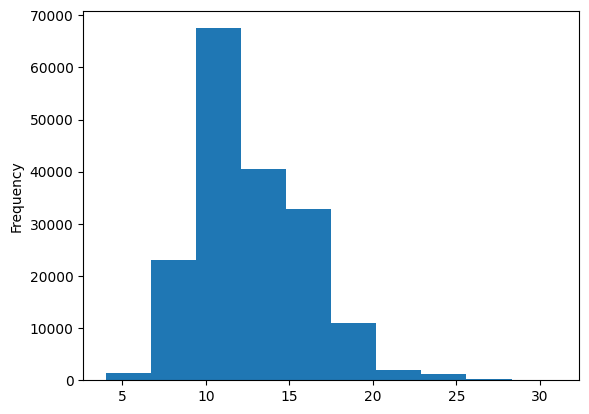

In [ ]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [ ]:
# Convert abstract text lines to lists
train_sentences = train_df["text"].to_list()
val_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# View the first 10 lines of the training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric data, they also require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from label encoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of different models and seeing which one works best.

And as always, we're going to start with a baseline(TF-IDF Multinomial Naive Bayes classifier).

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

## Download helper functions script
In the previous module, we wrote a function to compare predictions across different metrics (accuracy, precision, recall, F1-score) and rather than rewriting it here, let's download it from our helper functions script.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-09-02 14:15:07--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-09-02 14:15:08 (77.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for fdeep sequence models

Before we start building our deeper models, we've got to create vectorizaton and embedding layers.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentence on average ?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

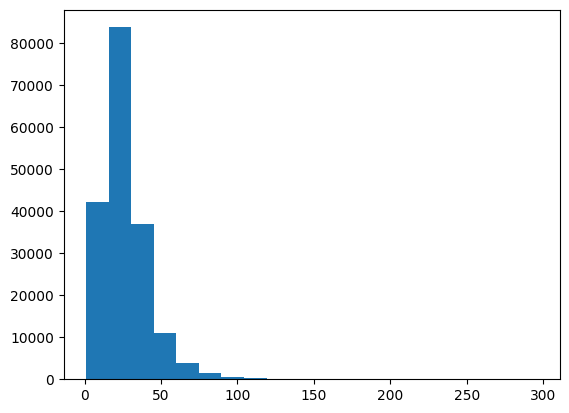

In [ ]:
# What's the distribution look like ?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [ ]:
# How long of a sentence covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [ ]:
# How many words are in our vocabulary ? (taken from table 2 in pdf)
max_tokens = 68000

In [ ]:
# Create a text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [ ]:
# Adapt text_vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text:\n {len(target_sentence)}")
print(f"\nVectorized text:\n {text_vectorizer(target_sentence.split())}")
print(f"\nLength of vectorized text:\n {len(text_vectorizer([target_sentence]))}")

Text:
 patients with stage iii/iv resectable head and neck squamous cell carcinoma were randomized to surgery followed by rt or ccrt .

Length of text:
 127

Vectorized text:
 [[  12    0    0 ...    0    0    0]
 [   7    0    0 ...    0    0    0]
 [ 531    0    0 ...    0    0    0]
 ...
 [  16    0    0 ...    0    0    0]
 [7255    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]

Length of vectorized text:
 1


In [ ]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Top 5 most common words: {rct_20k_text_vocab[:5]}")
print(f"Bottom 5 least common words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Top 5 most common words: ['', '[UNK]', 'the', 'and', 'of']
Bottom 5 least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text_vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim = 128, # Note: different embedding sizes result in drastically different sizes of parameters to train
                               mask_zero = True, # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [ ]:
# Show an example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Shape of embedded sentence:\n {embedded_sentence.shape}")

Sentence before vectorization:
 patients with stage iii/iv resectable head and neck squamous cell carcinoma were randomized to surgery followed by rt or ccrt .

Sentence after vectorization (before embedding):
 [[  12    7  531 6185 7300 1331    3  932 4619  507 1440    9   29    6
   115  284   22 1095   16 7255    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.02454619  0.00023599 -0.02444463 ... -0.022552   -0.04585155
   -0.04712247]
  [-0.00879901 -0.04993704 -0.00141471 ...  0.03293983 -0.04913882
   -0.03328526]
  [ 0.03600181  0.02443949 -0.00563819 ...  0.01455407 -0.01336281
    0.00085812]
  ...
  [ 0.03022117  0.03243425 -0.00968224 ... -0.03236888 -0.02527928
    0.04837836]
  [ 0.03022117  0.03243425 -0.00968224 ... -0.03236888 -0.02527928
    0.04837836]
  [ 0.03022117  0.03243425 -0.00968224 ... -0.03236888 

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API, many of the steps here are discussed at length in these two resources :
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [ ]:
# Turn our data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset, val_dataset, test_dataset

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

In [ ]:
# Take the TensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset, val_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector form conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                    

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps = int(0.1 * len(val_dataset))) # only validate on 10% of the data

Epoch 1/3
562/562 [==============================] - 21s 32ms/step - loss: 0.9096 - accuracy: 0.6400 - val_loss: 0.6864 - val_accuracy: 0.7340
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6606 - accuracy: 0.7519 - val_loss: 0.6390 - val_accuracy: 0.7680
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6213 - accuracy: 0.7727 - val_loss: 0.6001 - val_accuracy: 0.7816


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6011 - accuracy: 0.7849


[0.6011207103729248, 0.7848536968231201]

In [ ]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 2s 2ms/step


(array([[4.0099218e-01, 2.1697499e-01, 7.0379697e-02, 2.7427101e-01,
         3.7382200e-02],
        [4.3288320e-01, 3.2385138e-01, 1.1183839e-02, 2.2280152e-01,
         9.2799822e-03],
        [1.8008643e-01, 1.0721195e-02, 2.2310009e-03, 8.0691308e-01,
         4.8248174e-05],
        ...,
        [6.3462489e-06, 6.5897976e-04, 1.0119893e-03, 3.5571911e-06,
         9.9831909e-01],
        [5.2907035e-02, 4.8389488e-01, 8.1045456e-02, 7.1251571e-02,
         3.1090108e-01],
        [1.7327568e-01, 6.6476977e-01, 4.5381915e-02, 4.5210611e-02,
         7.1362056e-02]], dtype=float32),
 (30212, 5))

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.48537005163512,
 'precision': 0.7813028708243923,
 'recall': 0.7848537005163512,
 'f1': 0.7821852447612673}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

Here, we can see that we've already beat the baseline model, let's build more models further to improve the results even more.

## Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specifically the universal sentence encoder (USE) : https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random Sentence:\n {random_train_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding:\n {len(use_embedded_sentence[0])}")

Random Sentence:
 objective pco assessment resulted in a mean pco score ( scale @-@ ) of @ was found for the corneal j@d group and a score of @ was found for the corneal a@d group ( p > @ ) .

Sentence after embedding:
 [-0.01802811 -0.04011983  0.039552    0.00698578  0.05330688  0.05695429
 -0.03917615  0.01665497 -0.03382353 -0.01957732  0.07120212  0.04649854
 -0.03488247  0.05165797  0.06297681  0.0356151  -0.01818537 -0.00346021
  0.02188957  0.01222319 -0.06479126  0.02106623 -0.04631111 -0.00378186
  0.04827685  0.02641159 -0.00514895  0.00234413 -0.02602232 -0.01054108]

Length of sentence embedding:
 512


## Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [ ]:
# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note : We could add more layers here if we wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs, outputs, name="model_2_use")

# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit model 2 to the data
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps = int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 16ms/step - loss: 0.9144 - accuracy: 0.6505 - val_loss: 0.7967 - val_accuracy: 0.6905
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7679 - accuracy: 0.7021 - val_loss: 0.7552 - val_accuracy: 0.7058
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7507 - accuracy: 0.7139 - val_loss: 0.7372 - val_accuracy: 0.7181


In [ ]:
# Evaluate on the whole validation dataset
model_2.evaluate(val_dataset)

945/945 [==============================] - 11s 11ms/step - loss: 0.7399 - accuracy: 0.7142


[0.7399210929870605, 0.7141532897949219]

In [ ]:
# Make predictions with our feature extraction dataset
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs

945/945 [==============================] - 10s 11ms/step


array([[0.43030038, 0.35709623, 0.00233151, 0.20195688, 0.00831493],
       [0.33296695, 0.52269596, 0.00457564, 0.13702261, 0.00273883],
       [0.2180269 , 0.1602005 , 0.01676266, 0.5595123 , 0.04549755],
       ...,
       [0.00156528, 0.00492699, 0.04685218, 0.00096908, 0.9456865 ],
       [0.00395061, 0.04681797, 0.22008188, 0.00150024, 0.7276493 ],
       [0.17044207, 0.24031566, 0.5048252 , 0.01051558, 0.0739015 ]],
      dtype=float32)

In [ ]:
# Convert the prediction probabilities found with the feature extraction model to labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.4153316562955,
 'precision': 0.7148443855134143,
 'recall': 0.7141533165629551,
 'f1': 0.7111865032848426}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states that they used a combination of token and character-level embeddings.

Previously we've used token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings.

### Creating a character level tokenizer


In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'o b j e c t i v e   p c o   a s s e s s m e n t   r e s u l t e d   i n   a   m e a n   p c o   s c o r e   (   s c a l e   @ - @   )   o f   @   w a s   f o u n d   f o r   t h e   c o r n e a l   j @ d   g r o u p   a n d   a   s c o r e   o f   @   w a s   f o u n d   f o r   t h e   c o r n e a l   a @ d   g r o u p   (   p   >   @   )   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
# What's the average character length ?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

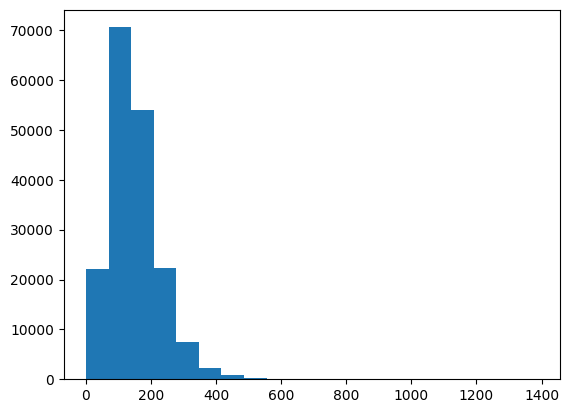

In [ ]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20);

In [ ]:
# Find what character length covers 95% of our sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
 # Get all keyboard characters
 import string
 alphabet = string.ascii_lowercase + string.digits + string.punctuation
 alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV tokens
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [ ]:
# Adapt character vectorizer to our training character
char_vectorizer.adapt(train_chars)

In [ ]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of characters in character vocab: {len(char_vocab)}")
print(f"Top 5 most common characters in vocab: {char_vocab[:5]}")
print(f"Bottom 5 least common characters in vocab: {char_vocab[-5:]}")

Number of characters in character vocab: 28
Top 5 most common characters in vocab: ['', '[UNK]', 'e', 't', 'i']
Bottom 5 least common characters in vocab: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}\n")
print(f"Length of random_train_chars:\n {len(random_train_chars.split())}\n")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"Vectorized chars:\n {vectorized_chars}\n")
print(f"Length of vectorized text:\n {len(vectorized_chars[0])}")

Charified text:
 o u t c o m e s   w e r e   t h r e e - m o n t h   c h a n g e s   i n   t h e   s h o r t   f o r m   h e a l t h   s u r v e y   (   s f - @   )   m e n t a l   h e a l t h   c o m p o n e n t   s u m m a r y   s c o r e   (   m c s   )   a n d   p h y s i c a l   h e a l t h   c o m p o n e n t   s u m m a r y   s c o r e   (   p c s   )   .

Length of random_train_chars:
 144

Vectorized chars:
 [[ 7 16  3 11  7 15  2  9 20  2  8  2  3 13  8  2  2 15  7  6  3 13 11 13
   5  6 18  2  9  4  6  3 13  2  9 13  7  8  3 17  7  8 15 13  2  5 12  3
  13  9 16  8 21  2 19  9 17 15  2  6  3  5 12 13  2  5 12  3 13 11  7 15
  14  7  6  2  6  3  9 16 15 15  5  8 19  9 11  7  8  2 15 11  9  5  6 10
  14 13 19  9  4 11  5 12 13  2  5 12  3 13 11  7 15 14  7  6  2  6  3  9
  16 15 15  5  8 19  9 11  7  8  2 14 11  9  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

## Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper
                              mask_zero=True,
                              name="char_embed")

In [ ]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Shape of embedded chars:\n {char_embed_example.shape}")

Charified text:
 o u t c o m e s   w e r e   t h r e e - m o n t h   c h a n g e s   i n   t h e   s h o r t   f o r m   h e a l t h   s u r v e y   (   s f - @   )   m e n t a l   h e a l t h   c o m p o n e n t   s u m m a r y   s c o r e   (   m c s   )   a n d   p h y s i c a l   h e a l t h   c o m p o n e n t   s u m m a r y   s c o r e   (   p c s   )   .

Embedded chars (after vectorization and embedding):
 [[[-0.00356125 -0.04174126 -0.02171342 ... -0.01290495  0.01534958
   -0.03712969]
  [-0.04422226 -0.02800444 -0.02616677 ...  0.00196229 -0.02469349
    0.03971403]
  [ 0.04985894 -0.04337765  0.04349054 ...  0.02425935 -0.01033183
   -0.01801559]
  ...
  [-0.0005231  -0.02790444 -0.00159536 ... -0.039543   -0.04994811
   -0.04296265]
  [-0.0005231  -0.02790444 -0.00159536 ... -0.039543   -0.04994811
   -0.04296265]
  [-0.0005231  -0.02790444 -0.00159536 ... -0.039543   -0.04994811
   -0.04296265]]]

Shape of embedded chars:
 (1, 290, 25)


### Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs) # vectorize text inputs
char_embeddings = char_embed(char_vectors) # create embedding
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x) # condense the output of our feature vector form conv layer
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_conv1D_char_embeddings")

# Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Summary of our model
model_3.summary()

Model: "model_3_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset, val_char_dataset, test_char_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 7ms/step - loss: 1.2655 - accuracy: 0.4786 - val_loss: 1.0303 - val_accuracy: 0.6031
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9872 - accuracy: 0.6079 - val_loss: 0.9350 - val_accuracy: 0.6360
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9118 - accuracy: 0.6433 - val_loss: 0.8527 - val_accuracy: 0.6759


In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.12567368, 0.55209416, 0.08688297, 0.19915816, 0.03619099],
       [0.1999659 , 0.3853983 , 0.0350528 , 0.3305815 , 0.04900153],
       [0.11672918, 0.1764305 , 0.15693064, 0.5274434 , 0.02246627],
       ...,
       [0.02547557, 0.02516029, 0.21492286, 0.02278581, 0.7116555 ],
       [0.03637941, 0.03779868, 0.39697987, 0.064648  , 0.46419412],
       [0.23691571, 0.48893374, 0.16949433, 0.07756282, 0.02709344]],
      dtype=float32)

In [ ]:
# Convert prediction probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 66.06315371375612,
 'precision': 0.6544577397132115,
 'recall': 0.6606315371375613,
 'f1': 0.6521810036635403}

## Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

1. Create a token-level embedding model (similar to `model_1`)
2. Create a character-level model (similar to `model_3` with a slight modification)
3. Combine 1 & 2 with a concatenate layer (`layers.concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of the paper.
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilites as output.

In [ ]:
# 1. Setup the token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_output)

# 2. Setup char inputs/models
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-LSTM layer
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# 3. Concatenate token and char inputs (create a hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in dropout (discussed in section 4.2 of the paper)
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                      outputs=output_layer,
                      name="model_4_token_and_char_embeddings")

In [ ]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

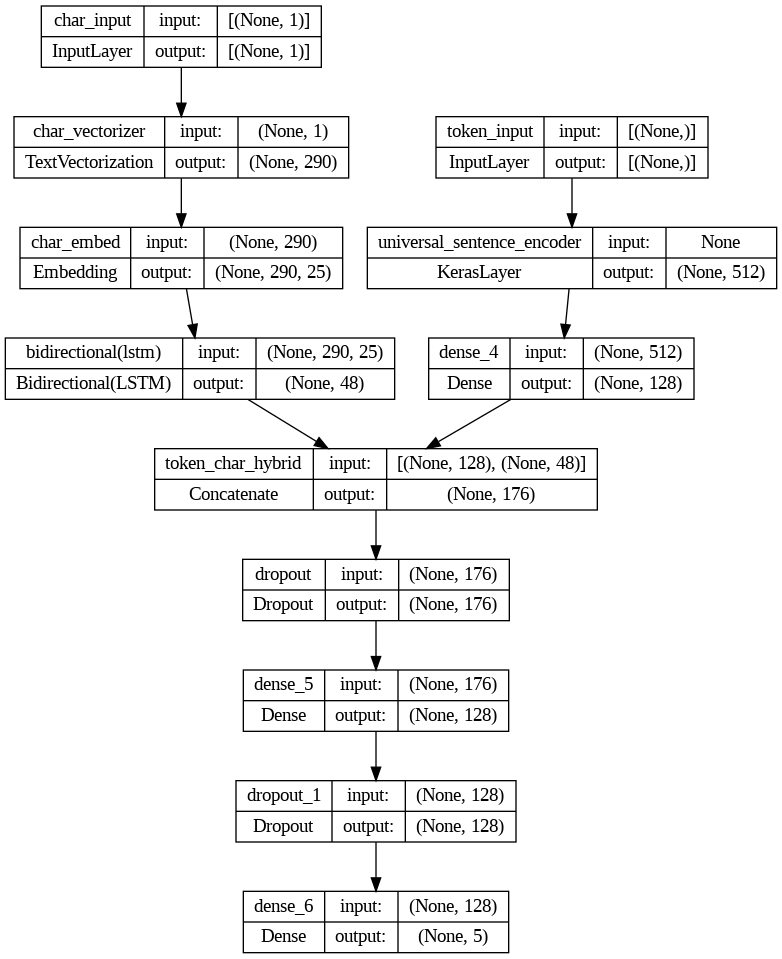

In [ ]:
# Plot hybrid token an character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), #section 4.2 in the paper used SGD, but we're sticking with adam
                metrics=["accuracy"])

### Combining token and character into a tf.data dataset

In [ ]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

# Prefetch and batch validation data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 53ms/step - loss: 0.9846 - accuracy: 0.6116 - val_loss: 0.7689 - val_accuracy: 0.6998
Epoch 2/3
562/562 [==============================] - 26s 47ms/step - loss: 0.8009 - accuracy: 0.6921 - val_loss: 0.7071 - val_accuracy: 0.7317
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7734 - accuracy: 0.6993 - val_loss: 0.6897 - val_accuracy: 0.7477


In [ ]:
# Evaluate on the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 20s 22ms/step - loss: 0.6986 - accuracy: 0.7361


[0.698586106300354, 0.7360982298851013]

In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 21s 19ms/step


array([[3.9955631e-01, 3.8651645e-01, 3.4716188e-03, 2.0379913e-01,
        6.6564591e-03],
       [3.6199307e-01, 3.7493423e-01, 1.5884436e-03, 2.5974387e-01,
        1.7403899e-03],
       [3.1491762e-01, 1.4328654e-01, 6.0326759e-02, 4.4818357e-01,
        3.3285566e-02],
       ...,
       [7.6489267e-04, 8.8162944e-03, 7.6739408e-02, 5.2728789e-04,
        9.1315210e-01],
       [6.3268822e-03, 4.8787631e-02, 2.2795756e-01, 4.4388003e-03,
        7.1248919e-01],
       [3.3232075e-01, 4.1615418e-01, 1.5646978e-01, 4.5230616e-02,
        4.9824689e-02]], dtype=float32)

In [ ]:
# Format pred_probs into pred_labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [ ]:
# Get the results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 73.60982391102873,
 'precision': 0.7371389748493671,
 'recall': 0.7360982391102873,
 'f1': 0.7338690547268851}

## Model 5 : Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12
1,METHODS,a total of @ patients with primary knee oa wer...,1,12
2,METHODS,outcome measures included pain reduction and i...,2,12
3,METHODS,pain was assessed using the visual analog pain...,3,12
4,METHODS,secondary outcome measures included the wester...,4,12


>🔑**Note:** Any engineered features used to train a model need to be available at test time. In our case, line numbers and total lines are available.

### Create positional embeddings

In [ ]:
# How many different line numbers are there ?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

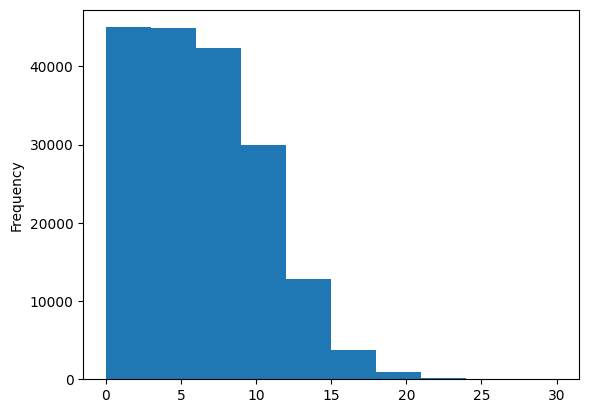

In [ ]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# Use TensorFlow to create one-hot encoded tensors of our "line_number" column
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_number_one_hot[:10], train_line_number_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

Now we've encoded our line_number feature , let's do the same for our total_lines feature...

In [ ]:
# How many different numbers of lines are there ?
train_df["total_lines"].value_counts()

,count
total_lines,
12,24468
11,23639
13,22113
10,19400
14,18438
15,14610
9,12285
16,10768
8,7464


<Axes: ylabel='Frequency'>

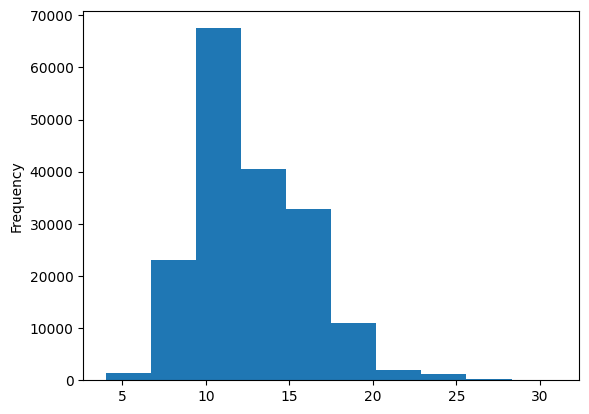

In [ ]:
# Check the distributions of total lines
train_df.total_lines.plot.hist()

In [ ]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 97)

20.0

In [ ]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1

### Building a tribrid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line_number" feature
4. Create a model for the "total_lines" feature
5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3, 4 & 5 using tf.keras.layers.Concatenate
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs for 1, 2, 3, 4, and outputs of 7 into a tf.keras.Model

In [ ]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
# inputs & shape
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# dense layer with 32 units and relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs and dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
# inputs & shape
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
# dense layer with 32 units and relu activation
y = layers.Dense(32, activation="relu")(total_lines_inputs)
# combine inputs and dense layer into model
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="combined_embeddings")([token_model.output,
                                                                      char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="combined_positional")([line_number_model.output,
                                                                     total_lines_model.output,
                                                                     z])

# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kind of inputs
model_5 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_number_model.input,
                                 total_lines_model.input],
                         outputs=output_layer)

In [ ]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']   

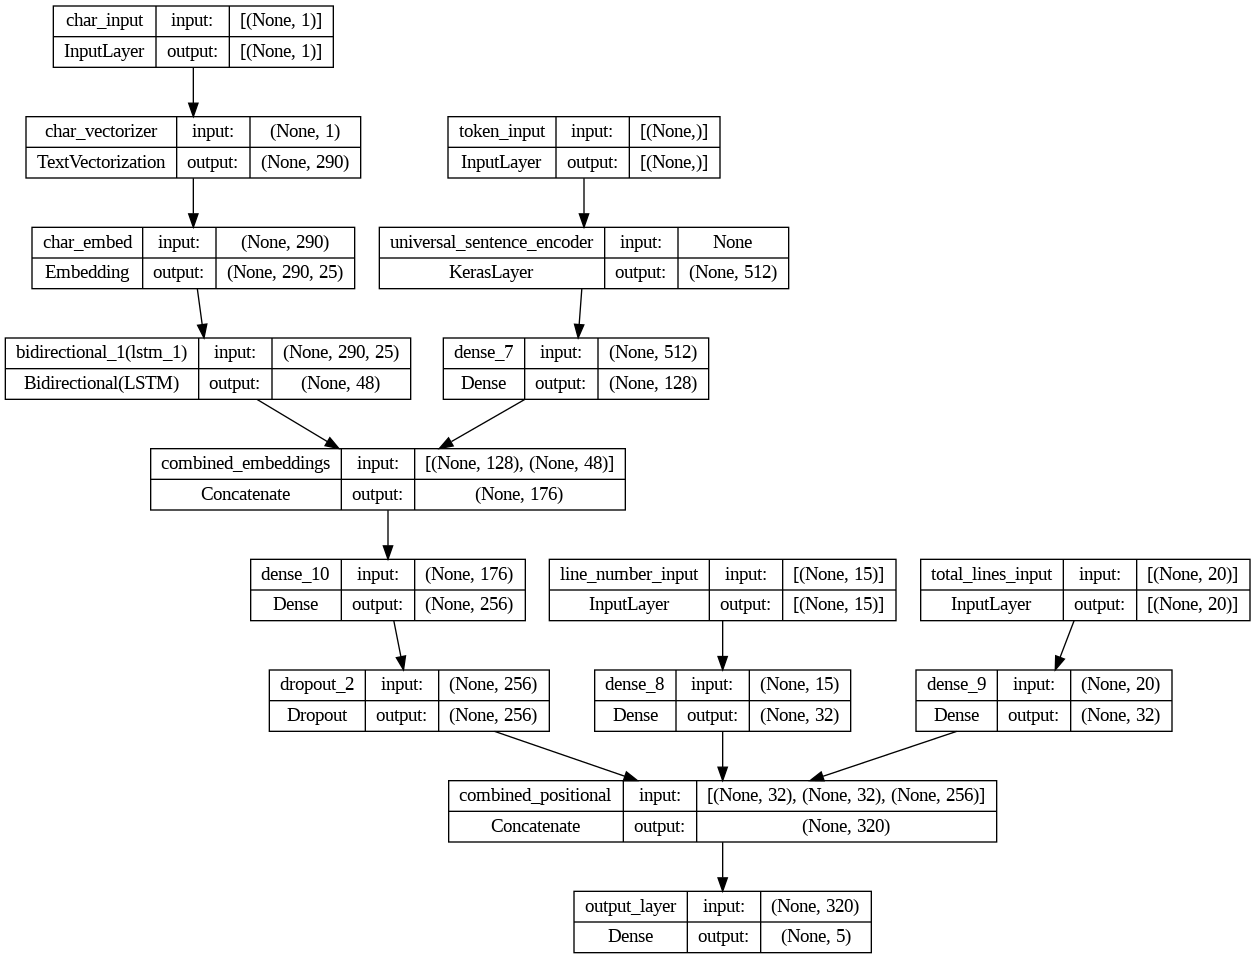

In [ ]:
# Plot model_5 to explore it visually...
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing ?

For example , if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that class and not consider other classes...

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the value from the highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01, 0.01]`

>📖**Resource:** For more on label smoothing , see the blog post from PyImageSearch

In [ ]:
# Compile token, char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="Adam",
                metrics=["accuracy"])

### Create tribrid embedding datasets using tf.data


In [ ]:
# Create training and validation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars, train_line_number_one_hot, train_total_lines_one_hot))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat for validation data
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars, val_line_number_one_hot, val_total_lines_one_hot))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch = int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps = int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 41s 56ms/step - loss: 1.0917 - accuracy: 0.7258 - val_loss: 0.9782 - val_accuracy: 0.8019
Epoch 2/3
562/562 [==============================] - 28s 50ms/step - loss: 0.9667 - accuracy: 0.8153 - val_loss: 0.9490 - val_accuracy: 0.8271
Epoch 3/3
562/562 [==============================] - 25s 45ms/step - loss: 0.9505 - accuracy: 0.8218 - val_loss: 0.9386 - val_accuracy: 0.8328


In [ ]:
# Make predictions with the char_token_pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 22s 20ms/step


array([[0.48825917, 0.11443482, 0.01278997, 0.3645956 , 0.01992048],
       [0.5005966 , 0.10633911, 0.06062087, 0.3200213 , 0.0124221 ],
       [0.2732376 , 0.12667266, 0.15233418, 0.3815087 , 0.06624694],
       ...,
       [0.0340605 , 0.12036058, 0.04545934, 0.02760639, 0.7725132 ],
       [0.02834765, 0.3504329 , 0.08919345, 0.0269989 , 0.5050271 ],
       [0.14714898, 0.60980463, 0.13387753, 0.03803249, 0.07113636]],
      dtype=float32)

In [ ]:
# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.4072553952072,
 'precision': 0.8329354601792406,
 'recall': 0.834072553952072,
 'f1': 0.8326912166954082}

## Compare model results

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                   "model_1_custom_token_embedding": model_1_results,
                                   "model_2_pretrained_token_embedding": model_2_results,
                                   "model_3_custom_char_embedding": model_3_results,
                                   "model_4_hybrid_char_token_embedding": model_4_results,
                                   "model_5_pos_char_token_embedding": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.485370,0.781303,0.784854,0.782185
model_2_pretrained_token_embedding,71.415332,0.714844,0.714153,0.711187
model_3_custom_char_embedding,66.063154,0.654458,0.660632,0.652181
model_4_hybrid_char_token_embedding,73.609824,0.737139,0.736098,0.733869
model_5_pos_char_token_embedding,83.407255,0.832935,0.834073,0.832691


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

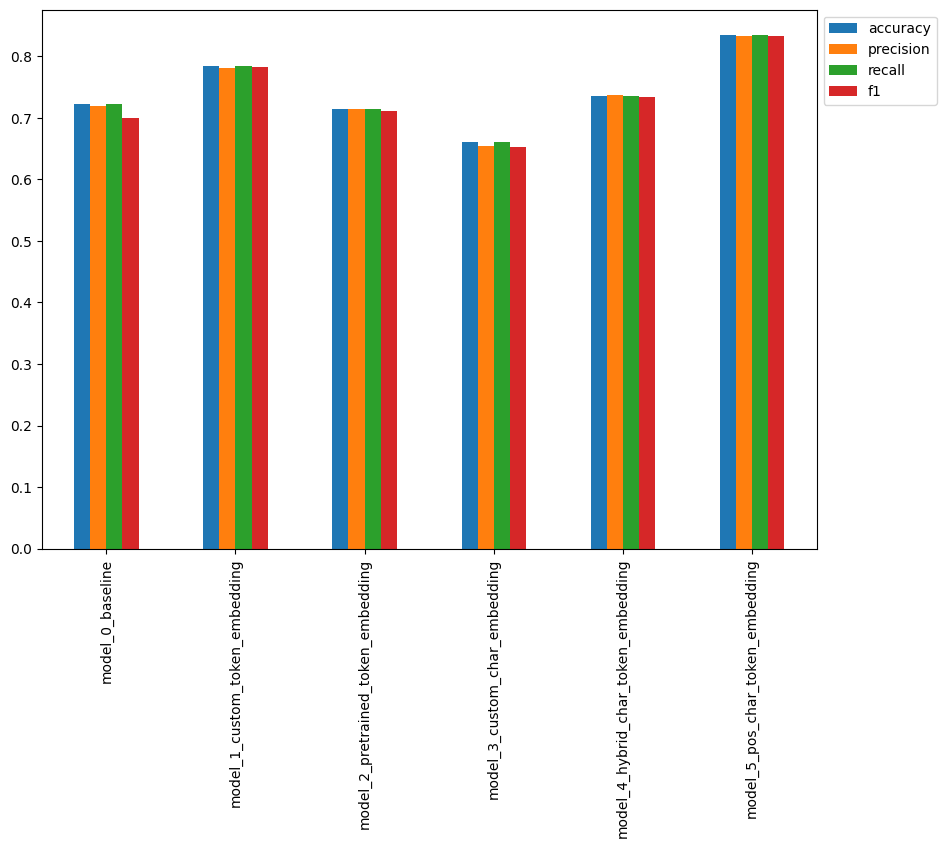

In [ ]:
# Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

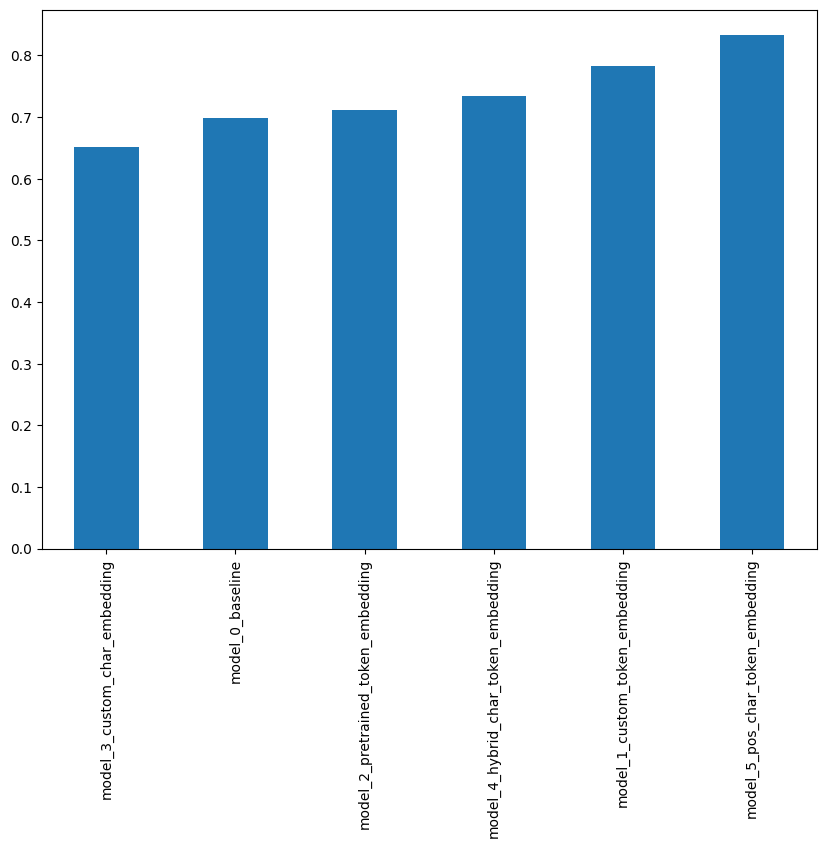

In [ ]:
# Sort the models results according to f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

## Save and load model

In [ ]:
# Save the best performing model to the SavedModel format (default)
model_5.save("SkimLit_tribrid_embedding_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("SkimLit_tribrid_embedding_model")

In [ ]:
# Make predictions with loaded model on the validation set
loaded_model_pred_probs = loaded_model.predict(val_char_token_pos_dataset)
loaded_preds = tf.argmax(loaded_model_pred_probs, axis=1)
loaded_preds[:10]

945/945 [==============================] - 23s 21ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

{'accuracy': 83.4072553952072,
 'precision': 0.8329354601792406,
 'recall': 0.834072553952072,
 'f1': 0.8326912166954082}

In [ ]:
model_5_results

{'accuracy': 83.4072553952072,
 'precision': 0.8329354601792406,
 'recall': 0.834072553952072,
 'f1': 0.8326912166954082}

In [ ]:
assert model_5_results == loaded_model_results # Would give error if it wasn't true

In [ ]:
# Checking the loaded model summary
loaded_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token_input[0][0]']   

# END OF PROJECT

**This later part is for experimental purposes only.**

## Your Challenges

1. Turn the test data samples into a tf.data.Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples.
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probabiltiy).
3. Make example predictions (on RCT abstracts from the wild), we can go to PubMed to find these : https://pubmed.ncbi.nlm.nih.gov/, find and use our model to predict on 3-4 abstracts from the wild.
 * Some examples: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json
4. See the exercises and extra-curriculum on GitHub , and try to solve them.

### Evaluating on test data

In [ ]:
# Creating test_char_token_pos_Dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars, test_line_number_one_hot, test_total_lines_one_hot))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Evaluate the test data with our best performing models
model_5.evaluate(test_char_token_pos_dataset)

942/942 [==============================] - 21s 22ms/step - loss: 0.9439 - accuracy: 0.8277


[0.94388347864151, 0.827741801738739]

In [ ]:
# Make predictions with the best_model on validation data
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset)
model_5_preds = (tf.round(model_5_pred_probs))
model_5_preds[:10] # these should be in label format

945/945 [==============================] - 19s 20ms/step


<tf.Tensor: shape=(10, 5), dtype=float32, numpy=
array([[0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

### Finding out the most wrong predictions

In [ ]:
# Create a DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": np.array(val_sentences).flatten(),
                       "target": val_labels_encoded,
                       "pred": np.argmax(model_5_preds, axis=1), # Get the index of the class with highest probability
                       "pred_prob": tf.squeeze(tf.reduce_max(model_5_pred_probs, axis=1))}) # Get the highest probability for each sample
val_df.head()

,text,target,pred,pred_prob
0,ige sensitization to aspergillus fumigatus and...,0,0,0.488259
1,it is not clear whether these patients would b...,0,0,0.500597
2,we sought to determine whether a @-month cours...,3,0,0.381509
3,asthmatic patients who were ige sensitized to ...,2,2,0.721598
4,primary outcomes were improvement in quality o...,2,2,0.693473


In [ ]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
28193,primary outcome measures were symptom self-rat...,4,2,0.933388
15279,to assess the short-term efficacy and safety o...,0,3,0.924459
18115,to test the hypothesis that the administration...,0,3,0.923645
25081,"the resource consumption , costs , and health-...",3,2,0.923115
10034,secondary outcomes included time to tb treatme...,4,2,0.920944
28492,clinicaltrials.gov id : nct@ .,1,0,0.918967
16173,a qol questionnaire including a pain scale wil...,1,2,0.915548
9498,( clinicaltrials.gov nct@ ) .,2,0,0.908425
28639,no difference was found between children with ...,1,4,0.906175
892,clinicaltrials.gov : nct@ .,2,0,0.905295


In [ ]:
most_wrong.tail() # these are false negeatives

,text,target,pred,pred_prob
30045,we performed an open-label randomized controll...,2,0,0.249014
29145,"we are starting a two-phase , mixed-method tri...",2,0,0.247008
13487,we also examined the moderating role of parent...,2,0,0.246532
24692,"in the test group , diode laser was used for v...",2,0,0.237872
1604,there are no enough studies and research on th...,3,0,0.217423


In [ ]:
# Check the false positives
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 4, Pred: 2, Prob: 0.9333879947662354
Text:
primary outcome measures were symptom self-rating scales ( insomnia severity index -lsb- isi -rsb- and the montgomery sberg depression rating scale -lsb- madrs-s -rsb- ) , assessed before and after treatment with follow-up after @ and @ mo. .

----

Target: 0, Pred: 3, Prob: 0.9244587421417236
Text:
to assess the short-term efficacy and safety of corneal collagen cross-linking ( cxl ) in preventing the progression of keratoconus ( kcn ) .

----

Target: 0, Pred: 3, Prob: 0.9236451387405396
Text:
to test the hypothesis that the administration of antithrombin concentrate improves disseminated intravascular coagulation ( dic ) , resulting in recovery from dic and better outcomes in patients with sepsis , we conducted a prospective , randomized controlled multicenter trial at @ critical care centers in tertiary care hospitals .

----

Target: 3, Pred: 2, Prob: 0.9231147766113281
Text:
the resource consumption , costs , and health-related q

In [ ]:
# Check the false negeatives
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 3, Pred: 0, Prob: 0.25538209080696106
Text:
this study aims to compare the complication rates and tissue yield of these two methods in nigerian men .

----

Target: 4, Pred: 0, Prob: 0.2534535229206085
Text:
one thousand seven hundred and fifty-eight roadmap patients ( placebo arm : @ ; om arm : @ ) participated in the observational follow up ( ofu ) with an average of @ years .

----

Target: 4, Pred: 0, Prob: 0.25268369913101196
Text:
curvature ( or the nonlinear effect ) of experiential avoidance during treatment significantly mediated posttreatment social anxiety symptoms and anhedonic depression in act , but not in cbt , with steeper decline of the acceptance and action questionnaire at the beginning of treatment predicting fewer symptoms in act only .

----

Target: 2, Pred: 0, Prob: 0.2524600028991699
Text:
the primary aims are to evaluate the efficacy , safety , and feasibility of a @-week tai chi program for patients with copd .

----

Target: 4, Pred: 0, Prob: 0.25005

### Checking model performance on data from the wild

In [ ]:
import json
# Download and open example abstracts (copy and pasted from PubMed)
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json

with open("skimlit_example_abstracts.json", "r") as f:
  example_abstracts = json.load(f)

example_abstracts

--2024-09-02 16:22:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/skimlit_example_abstracts.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6737 (6.6K) [text/plain]
Saving to: ‘skimlit_example_abstracts.json’

skimlit_example_abs 100%[===================>]   6.58K  --.-KB/s    in 0s      

2024-09-02 16:22:57 (90.4 MB/s) - ‘skimlit_example_abstracts.json’ saved [6737/6737]



[{'abstract': 'This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.',
  'source': 'https://pubmed.ncbi.nlm.nih.gov/20232240/',
  'details': 'RCT of a manualiz